# MLC Assignment 1: End-to-End Model Execution

## Section 1: Model Preparation

To get you familiar with the process of building and manipulating an end-to-end model using MLC, let's start from a simple image classification model.

We first use the following commands to install necessary packages.

In [1]:
!python3 -m pip install mlc-ai-nightly -f https://mlc.ai/wheels
!python3 -m pip install torch torchvision torchaudio torchsummary --extra-index-url https://download.pytorch.org/whl/cpu

Looking in links: https://mlc.ai/wheels
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cpu


In [2]:
import numpy as np
import pickle as pkl
import torch
import torch.nn.functional as F
import torchvision
import tvm
import tvm.testing

from matplotlib import pyplot as plt
from torch import nn
from torchvision import transforms
from tvm import topi, relax, te
from tvm.script import tir as T

In [3]:
tvm.__version__

'0.15.dev0'

Below is the model defined in PyTorch. It accepts a batch of images as input, and pass them through convolution layer, activation layer, pooling layer and fully-connected layers in order.

In [4]:
batch_size = 4
input_shape = (batch_size, 1, 28, 28)  # NCHW layout

def pytorch_model():
    list = []
    list.append(nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3, 3), bias=True))
    list.append(nn.ReLU())
    list.append(nn.MaxPool2d(kernel_size=(2, 2)))
    list.append(nn.Flatten())
    list.append(nn.Linear(in_features=5408, out_features=100, bias=True))
    list.append(nn.ReLU())
    list.append(nn.Linear(in_features=100, out_features=10, bias=True))
    list.append(nn.Softmax(dim=1))

    model = nn.Sequential(*list).cpu()
    name_map = {
        "0.weight": "conv2d_weight",
        "0.bias": "conv2d_bias",
        "4.weight": "linear0_weight",
        "4.bias": "linear0_bias",
        "6.weight": "linear1_weight",
        "6.bias": "linear1_bias",
    }
    for name, param in model.named_parameters():
        param.data = torch.from_numpy(weight_map[name_map[name]]).cpu()
    return model

We provide a pre-trained weight map for this model on the Fashion MNIST dataset.

In [5]:
# Hide outputs
!wget -nc https://github.com/mlc-ai/web-data/raw/main/models/fasionmnist_mlp_assignment_params.pkl

File ‘fasionmnist_mlp_assignment_params.pkl’ already there; not retrieving.



We can see that its accuracy is about 84%.

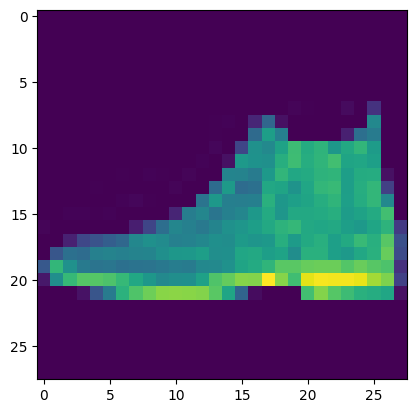

predict: Ankle boot, label: Ankle boot

Test set: Average loss: -0.8369, Accuracy: 8388/10000 (84%)



In [6]:
# Load the weight map from file.
# The prediction accuracy of the weight map on test data is around 83.3%.
weight_map = pkl.load(open("fasionmnist_mlp_assignment_params.pkl", "rb"))
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        print_img = True
        for data, label in test_loader:
            data, label = data.cpu(), label.cpu()
            output = model(data)
            # sum up batch loss
            test_loss += F.nll_loss(output, label, reduction="sum").item()
            # get the index of the max log-probability
            pred = output.argmax(dim=1, keepdim=True)
            if print_img:
                imshow(data[0])
                print("predict: {}, label: {}".format(class_names[pred[0][0]], class_names[label[0]]))
                print_img = False
            correct += pred.eq(label.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print("\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n".format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


test_data = torchvision.datasets.FashionMNIST(
    "./data",
    download=True,
    train=False,
    transform=transforms.Compose([transforms.ToTensor()])
)
test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size, shuffle=False)
test(pytorch_model(), test_loader)


## Section 2. Ingest Model From Pytorch

To see the MLC abstraction of the end-to-end model, we need to ingest it from PyTorch and transform into TVMScript implementation. However, it is hard to manually do this. As you may have experienced in Exercise 1, writing a primitive tensor function for each model layer requires massive engineering efforts. Moreover, the manual writing process is error-prone - just imagine when you write dozens of lines of code while there exists some tiny bug in your implementation, finding the bug in could be annoying.

Fortunately, in TVM there is a much simpler way of doing this. TVM provides a utility `relax.BlockBuilder` that can construct end-to-end models step by step in an IRModule that starts empty. (Recall that in Lecture 4 we introduced the dataflow block design of Relax, our MLC abstraction on computational graph level. And here the "block" in "`BlockBuilder`" stands for the dataflow blocks in Relax functions.)

Specifically, in `BlockBuilder` we have an `emit_te` API, that helps convert a Tensor Expression operator description, which was introduced in Lecture 3, into a `call_tir` operation to the operator's corresponding TensorIR function (`call_tir` was introduced in Lecture 4 as well.) Compared with manually writing TensorIR functions, writing their Tensor Expression description can be done within only a few lines of code, which reduces the amount of efforts and is less likely for us to make mistakes.

The signature of `emit_te` is `emit_te(func, *input)`, where `func` is a function that returns a Tensor Expression operator description, and `*input` is the inputs to `func`.

Let's start with an introducing example. In the code block below, `relu` is a function that returns a Tensor Expression description of a ReLU operator. To construct a Relax function that executes a single ReLU operator, in function `emit_te_example` we first define a BlockBuilder instance `bb`. We also define a 2-dimensional 128x128 tensor variable `x`, which will serve as the input tensor of the ReLU operation (as well as the input of the Relax function).

After that, we construct a Relax function `main` with `x` as input, using the `with bb.function(name, [*input])` API. Then we construct a dataflow block. Inside the dataflow block, we first have a `call_tir` to a TensorIR implementation of ReLU operator, through `emit_te`. The `emit_te` below generates a TensorIR function called "`relu`" in the IRModule, and add a `call_tir(relu, (x,), (128, 128), dtype="float32")` operation in the dataflow block. And the `call_tir` is followed by a function return.

After this construction, the BlockBuilder `bb` contains the constructed IRModule, which can be got by `bb.get()`.


In [7]:
def relu(A):
    B = te.compute(shape=(128, 128), fcompute=lambda i, j: te.max(A[i, j], 0), name="B")
    return B

def emit_te_example():
    bb = relax.BlockBuilder()
    # x = relax.Var("x", (128, 128), relax.DynTensorType(2, "float32"))
    x = relax.Var("x", relax.TensorStructInfo((128, 128), "float32"))
    with bb.function("main", [x]):
        with bb.dataflow():
            lv0 = bb.emit_te(relu, x)
            gv = bb.emit_output(lv0)
        bb.emit_func_output(gv)
    return bb.get()

The function `emit_te_example` returns the constructed IRModule as output. To see what the BlockBuilder constructs, we print the IRModule.

In [8]:
import IPython

mod = emit_te_example()
IPython.display.Code(mod.script(), language="python")

# from tvm.script import ir as I
# from tvm.script import tir as T
# from tvm.script import relax as R

@I.ir_module
class Module:
    @T.prim_func(private=True)
    def relu(A: T.Buffer((T.int64(128), T.int64(128)), "float32"), B: T.Buffer((T.int64(128), T.int64(128)), "float32")):
        T.func_attr({"tir.noalias": T.bool(True)})
        # with T.block("root"):
        for i, j in T.grid(T.int64(128), T.int64(128)):
            with T.block("B"):
                v_i, v_j = T.axis.remap("SS", [i, j])
                T.reads(A[v_i, v_j])
                T.writes(B[v_i, v_j])
                B[v_i, v_j] = T.max(A[v_i, v_j], T.float32(0))

    @R.function
    def main(x: R.Tensor((128, 128), dtype="float32")) -> R.Tensor((128, 128), dtype="float32"):
        cls = Module
        with R.dataflow():
            lv = R.call_tir(cls.relu, (x,), out_sinfo=R.Tensor((128, 128), dtype="float32"))
            gv: R.Tensor((128, 128), dtype="float32") = lv
            R.output(gv)
        return gv

As you can see, the IRModule generated by the BlockBuilder does contain a TensorIR implementation of ReLU, and a Relax function which calls into the ReLU implementation via `call_tir`.

Now it is your turn to use BlockBuilder and `emit_te` to create an IRModule equivalent to the PyTorch model defined above. You can write Tensor Expression descriptions for all the operators by yourself. Alternatively, TVM provides TOPI (short for "TVM Operator Inventory") library which wraps Tensor Expression descriptions for various operators. It is also encouraged if you can read the [documents](https://tvm.apache.org/docs/reference/api/python/topi.html) and find out a way to use them. The test function has been provided for you to check the correctness of your IRModule easily.

Note that each Conv2d layer or linear layer in the model contains a bias add, which should be reflected in the IRModule you construct.

In [42]:
def create_model_via_emit_te():
    bb = relax.BlockBuilder()
    # x = relax.Var("x", input_shape, relax.DynTensorType(batch_size, "float32"))
    x = relax.Var("x", relax.TensorStructInfo(input_shape, "float32"))

    conv2d_weight = relax.const(weight_map["conv2d_weight"], "float32")
    conv2d_bias = relax.const(weight_map["conv2d_bias"].reshape(1, 32, 1, 1), "float32")
    linear0_weight = relax.const(weight_map["linear0_weight"], "float32")
    linear0_bias = relax.const(weight_map["linear0_bias"].reshape(1, 100), "float32")
    linear1_weight = relax.const(weight_map["linear1_weight"], "float32")
    linear1_bias = relax.const(weight_map["linear1_bias"].reshape(1, 10), "float32")

    with bb.function("main", [x]):
        with bb.dataflow():
            lv0 = bb.emit_te(lambda w, y: topi.nn.conv2d_nchw(
                y, w, stride=1, padding=0, dilation=1), conv2d_weight, x)
            lv0b = bb.emit_te(lambda b, y: topi.add(y, b), conv2d_bias, lv0)
            lv0r = bb.emit_te(lambda y: topi.nn.relu(y), lv0b)
            lv1 = bb.emit_te(lambda y: topi.nn.pool2d(
                y, kernel=(2,2), stride=(2,2), dilation=(1,1), padding=(0,0,0,0), pool_type="max"), lv0r)
            lv1f = bb.emit_te(lambda y: topi.nn.flatten(y), lv1)
            lv1pb = bb.emit_te(lambda w, y: topi.nn.dense(y, w), linear0_weight, lv1f)
            lv1b = bb.emit_te(lambda b, y: topi.add(y, b), linear0_bias, lv1pb)
            lv1r = bb.emit_te(lambda y: topi.nn.relu(y), lv1b)
            lv2 = bb.emit_te(lambda w, y: topi.nn.dense(y, w), linear1_weight, lv1r)
            lv2b = bb.emit_te(lambda b, y: topi.add(y, b), linear1_bias, lv2)
            lv2s = bb.emit_te(lambda y: topi.nn.softmax(y, axis=1), lv2b)
            gv = bb.emit_output(lv2s)
        bb.emit_func_output(gv)

    return bb.get()

def build_mod(mod):
    # exec = relax.vm.build(mod, "llvm")
    exec = relax.build(mod, target="llvm")
    dev = tvm.cpu()
    vm = relax.VirtualMachine(exec, dev)
    return vm

def check_equivalence(mod, torch_model, test_loader):
    torch_model.eval()
    with torch.no_grad():
        rt_mod = build_mod(mod)
        for data, label in test_loader:
            data, label = data.cpu(), label.cpu()
            output_from_pytorch = torch_model(data).numpy()
            output_from_relax = rt_mod["main"](tvm.nd.array(data, tvm.cpu())).numpy()
            tvm.testing.assert_allclose(output_from_pytorch, output_from_relax, rtol=1e-4)

test_data = torchvision.datasets.FashionMNIST(
    "./data",
    download=True,
    train=False,
    transform=transforms.Compose([transforms.ToTensor()])
)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

mod = create_model_via_emit_te()
torch_model = pytorch_model()

check_equivalence(mod, torch_model, test_loader)
IPython.display.Code(mod.script(), language="python")

# from tvm.script import ir as I
# from tvm.script import tir as T
# from tvm.script import relax as R

@I.ir_module
class Module:
    @T.prim_func(private=True)
    def <lambda>(A: T.Buffer((T.int64(32), T.int64(1), T.int64(3), T.int64(3)), "float32"), B: T.Buffer((T.int64(4), T.int64(1), T.int64(28), T.int64(28)), "float32"), conv2d_nchw: T.Buffer((T.int64(4), T.int64(32), T.int64(26), T.int64(26)), "float32")):
        T.func_attr({"tir.noalias": T.bool(True)})
        # with T.block("root"):
        pad_temp = T.alloc_buffer((T.int64(4), T.int64(1), T.int64(28), T.int64(28)))
        for i0, i1, i2, i3 in T.grid(T.int64(4), T.int64(1), T.int64(28), T.int64(28)):
            with T.block("pad_temp"):
                v_i0, v_i1, v_i2, v_i3 = T.axis.remap("SSSS", [i0, i1, i2, i3])
                T.reads(B[v_i0, v_i1, v_i2, v_i3])
                T.writes(pad_temp[v_i0, v_i1, v_i2, v_i3])
                pad_temp[v_i0, v_i1, v_i2, v_i3] = B[v_i0, v_i1, v_i2, v_i3]
        for nn, ff, yy, xx, rc, ry, rx in T.grid(T.int64(4), T.int64(32), T.int64(26), T.int64(26), T.int64(1), T.int64(3), T.int64(3)):
            with T.block("conv2d_nchw"):
                v_nn, v_ff, v_yy, v_xx, v_rc, v_ry, v_rx = T.axis.remap("SSSSRRR", [nn, ff, yy, xx, rc, ry, rx])
                T.reads(pad_temp[v_nn, v_rc, v_yy + v_ry, v_xx + v_rx], A[v_ff, v_rc, v_ry, v_rx])
                T.writes(conv2d_nchw[v_nn, v_ff, v_yy, v_xx])
                with T.init():
                    conv2d_nchw[v_nn, v_ff, v_yy, v_xx] = T.float32(0)
                conv2d_nchw[v_nn, v_ff, v_yy, v_xx] = conv2d_nchw[v_nn, v_ff, v_yy, v_xx] + pad_temp[v_nn, v_rc, v_yy + v_ry, v_xx + v_rx] * A[v_ff, v_rc, v_ry, v_rx]

    @T.prim_func(private=True)
    def <lambda>1(A: T.Buffer((T.int64(1), T.int64(32), T.int64(1), T.int64(1)), "float32"), B: T.Buffer((T.int64(4), T.int64(32), T.int64(26), T.int64(26)), "float32"), T_add: T.Buffer((T.int64(4), T.int64(32), T.int64(26), T.int64(26)), "float32")):
        T.func_attr({"tir.noalias": T.bool(True)})
        # with T.block("root"):
        for ax0, ax1, ax2, ax3 in T.grid(T.int64(4), T.int64(32), T.int64(26), T.int64(26)):
            with T.block("T_add"):
                v_ax0, v_ax1, v_ax2, v_ax3 = T.axis.remap("SSSS", [ax0, ax1, ax2, ax3])
                T.reads(B[v_ax0, v_ax1, v_ax2, v_ax3], A[T.int64(0), v_ax1, T.int64(0), T.int64(0)])
                T.writes(T_add[v_ax0, v_ax1, v_ax2, v_ax3])
                T_add[v_ax0, v_ax1, v_ax2, v_ax3] = B[v_ax0, v_ax1, v_ax2, v_ax3] + A[T.int64(0), v_ax1, T.int64(0), T.int64(0)]

    @T.prim_func(private=True)
    def <lambda>10(A: T.Buffer((T.int64(4), T.int64(10)), "float32"), T_softmax_norm: T.Buffer((T.int64(4), T.int64(10)), "float32")):
        T.func_attr({"tir.noalias": T.bool(True)})
        # with T.block("root"):
        T_softmax_maxelem = T.alloc_buffer((T.int64(4),))
        T_softmax_exp = T.alloc_buffer((T.int64(4), T.int64(10)))
        T_softmax_expsum = T.alloc_buffer((T.int64(4),))
        for i0, k in T.grid(T.int64(4), T.int64(10)):
            with T.block("T_softmax_maxelem"):
                v_i0, v_k = T.axis.remap("SR", [i0, k])
                T.reads(A[v_i0, v_k])
                T.writes(T_softmax_maxelem[v_i0])
                with T.init():
                    T_softmax_maxelem[v_i0] = T.float32(-3.4028234663852886e+38)
                T_softmax_maxelem[v_i0] = T.max(T_softmax_maxelem[v_i0], A[v_i0, v_k])
        for i0, i1 in T.grid(T.int64(4), T.int64(10)):
            with T.block("T_softmax_exp"):
                v_i0, v_i1 = T.axis.remap("SS", [i0, i1])
                T.reads(A[v_i0, v_i1], T_softmax_maxelem[v_i0])
                T.writes(T_softmax_exp[v_i0, v_i1])
                T_softmax_exp[v_i0, v_i1] = T.exp(A[v_i0, v_i1] - T_softmax_maxelem[v_i0])
        for i0, k in T.grid(T.int64(4), T.int64(10)):
            with T.block("T_softmax_expsum"):
                v_i0, v_k = T.axis.remap("SR", [i0, k])
                T.reads(T_softma

## Section 3. Use of Vendor Library

As we have talked about in Lecture 4, we can integrate torch functions into an IRModule. The steps include registering an external runtime function and calling it inside the IRModule using `call_tir`.

Here is an example of using torch matmul and torch add to implement a linear layer. You can also find this example in the Lecture 4 notes.

```python
@tvm.register_func("env.linear", override=True)
def torch_linear(x: tvm.nd.NDArray,
                 w: tvm.nd.NDArray,
                 b: tvm.nd.NDArray,
                 out: tvm.nd.NDArray):
    x_torch = torch.from_dlpack(x)
    w_torch = torch.from_dlpack(w)
    b_torch = torch.from_dlpack(b)
    out_torch = torch.from_dlpack(out)
    torch.mm(x_torch, w_torch.T, out=out_torch)
    torch.add(out_torch, b_torch, out=out_torch)


@tvm.script.ir_module
class MyModuleWithExternCall:
    @R.function
    def main(x: Tensor((1, 784), "float32"),
             w0: Tensor((128, 784), "float32"),
             b0: Tensor((128,), "float32")):
        # block 0
        with R.dataflow():
            lv0 = R.call_tir("env.linear", (x, w0, b0), (1, 128), dtype="float32")
            ...
        return ...
```

Please register external functions for the convolution layer occurring in the IRModule you create in Section 2. You need to use NumPy or PyTorch as the function's implementation.

You may use `BlockBuilder.emit` to directly add a `call_tir` operation to the end of the Relax function being constructed.

In [ ]:


def create_model_with_torch_func():
    bb = relax.BlockBuilder()

    # x = relax.Var("x", input_shape, relax.DynTensorType(4, "float32"))
    x = relax.Var("x", relax.TensorStructInfo(input_shape, "float32"))

    conv2d_weight = relax.const(weight_map["conv2d_weight"], "float32")
    conv2d_bias = relax.const(weight_map["conv2d_bias"].reshape(1, 32, 1, 1), "float32")
    linear0_weight = relax.const(weight_map["linear0_weight"], "float32")
    linear0_bias = relax.const(weight_map["linear0_bias"].reshape(1, 100), "float32")
    linear1_weight = relax.const(weight_map["linear1_weight"], "float32")
    linear1_bias = relax.const(weight_map["linear1_bias"].reshape(1, 10), "float32")

    with bb.function("main", [x]):
        with bb.dataflow():
            # TODO:
            ...
        bb.emit_func_output(gv)

    return bb.get()


test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)
mod = create_model_with_torch_func()
check_equivalence(mod, torch_model, test_loader)

## Section 4. Transformation in End-to–End Models

In Exercise 1, we learned how to transform a single TensorIR Function. It is similar to do that in an end-to-end model.

Compared with the batch matmul program, let's focus on a more challenging one: conv2d.

To begin with, let's introduce some new primitives: 
 - `compute_inline`: It inlines a block into another to reduce memory usage and memory access.
 - `fuse`: The opposite for `split`. Fuse multiple axes. Here `fuse` is used together with `parallel` / `vectorize` / `unroll` to further increase parallelism.

In [ ]:
@T.prim_func
def before_inline(a: T.handle, c: T.handle) -> None:
    A = T.match_buffer(a, (128, 128))
    B = T.alloc_buffer((128, 128))
    C = T.match_buffer(c, (128, 128))
    for i, j in T.grid(128, 128):
        with T.block("B"):
            vi, vj = T.axis.remap("SS", [i, j])
            B[vi, vj] = A[vi, vj] * 2.0
    for i, j in T.grid(128, 128):
        with T.block("C"):
            vi, vj = T.axis.remap("SS", [i, j])
            C[vi, vj] = B[vi, vj] + 1.0


sch = tvm.tir.Schedule(before_inline)
sch.compute_inline(sch.get_block("B"))
IPython.display.Code(sch.mod["main"].script(), language="python")


In [ ]:
@T.prim_func
def before_fuse(a: T.handle, b: T.handle) -> None:
    A = T.match_buffer(a, (128, 128))
    B = T.match_buffer(b, (128, 128))
    for i, j in T.grid(128, 128):
        with T.block("B"):
            vi, vj = T.axis.remap("SS", [i, j])
            B[vi, vj] = A[vi, vj] * 2.0


sch = tvm.tir.Schedule(before_fuse)
i, j = sch.get_loops(sch.get_block("B"))
sch.fuse(i, j)
IPython.display.Code(sch.mod["main"].script(), language="python")


Now we first create a schedule for the IRModule, and then transform the conv2d TensorIR function inside. Similar to Exercise 1, we provide you with a target function. But please note that, the target function does NOT serve as a "standard transformation answer" for several reasons:
 - it may not have the best performance on every hardware,
 - the original conv2d TensorIR implementation may vary, according to the Tensor Expression description you used in Section 2:
   - if you described the conv2d computation along with the bias computation in Tensor Expression, then there should be a block which calculates the bias at the end of target TensorIR function,
   - if you described conv2d and bias computation separately, or you used the conv2d provided by TOPI, then the target function should not have the bias block at the end. The original function of the target is generated by using TOPI conv2d.


```python
@T.prim_func
def target_func(rxplaceholder: T.Buffer[(4, 1, 28, 28), "float32"], rxplaceholder_1: T.Buffer[(32, 1, 3, 3), "float32"], conv2d_nchw: T.Buffer[(4, 32, 26, 26), "float32"]) -> None:
    T.func_attr({"global_symbol": "conv2d", "tir.noalias": True})
    # body
    # with T.block("root")
    for i0_0_i1_0_i2_0_i3_0_fused in T.parallel(2704):
        for i0_1_i1_1_fused_init in T.unroll(8):
            for i2_1_i3_1_fused_init in T.vectorized(4):
                with T.block("conv2d_nchw_init"):
                    nn = T.axis.spatial(
                        4, i0_0_i1_0_i2_0_i3_0_fused // 1352 * 2 + i0_1_i1_1_fused_init // 4)
                    ff = T.axis.spatial(
                        32, i0_0_i1_0_i2_0_i3_0_fused % 1352 // 169 * 4 + i0_1_i1_1_fused_init % 4)
                    yy = T.axis.spatial(
                        26, i0_0_i1_0_i2_0_i3_0_fused % 169 // 13 * 2 + i2_1_i3_1_fused_init // 2)
                    xx = T.axis.spatial(
                        26, i0_0_i1_0_i2_0_i3_0_fused % 13 * 2 + i2_1_i3_1_fused_init % 2)
                    T.reads()
                    T.writes(conv2d_nchw[nn, ff, yy, xx])
                    conv2d_nchw[nn, ff, yy, xx] = T.float32(0)
        for i4, i5, i6 in T.grid(1, 3, 3):
            for i0_1_i1_1_fused in T.unroll(8):
                for i2_1_i3_1_fused in T.vectorized(4):
                    with T.block("conv2d_nchw_update"):
                        nn = T.axis.spatial(
                            4, i0_0_i1_0_i2_0_i3_0_fused // 1352 * 2 + i0_1_i1_1_fused // 4)
                        ff = T.axis.spatial(
                            32, i0_0_i1_0_i2_0_i3_0_fused % 1352 // 169 * 4 + i0_1_i1_1_fused % 4)
                        yy = T.axis.spatial(
                            26, i0_0_i1_0_i2_0_i3_0_fused % 169 // 13 * 2 + i2_1_i3_1_fused // 2)
                        xx = T.axis.spatial(
                            26, i0_0_i1_0_i2_0_i3_0_fused % 13 * 2 + i2_1_i3_1_fused % 2)
                        rc, ry, rx = T.axis.remap("RRR", [i4, i5, i6])
                        T.reads(conv2d_nchw[nn, ff, yy, xx], rxplaceholder[nn,
                                rc, yy + ry, xx + rx], rxplaceholder_1[ff, rc, ry, rx])
                        T.writes(conv2d_nchw[nn, ff, yy, xx])
                        conv2d_nchw[nn, ff, yy, xx] = conv2d_nchw[nn, ff, yy, xx] + \
                            rxplaceholder[nn, rc, yy + ry, xx +
                                          rx] * rxplaceholder_1[ff, rc, ry, rx]
```

Unlike Exercise 1, this time the schedule is created for an IRModule, instead of a TensorIR function. Therefore, when using `sch.get_block`, a concrete function name should be provided, as shown below.

In [ ]:
mod = create_model_via_emit_te()
sch = tvm.tir.Schedule(mod)

# Step 1. Get blocks
# block = sch.get_block(name="your_block_name", func_name="your_function_name")

# Step 2. Inline the padding block (if exists)

# Step 3. Get loops

# Step 4. Organize the loops

# Step 5. decompose reduction

# Step 6. fuse + vectorize / fuse + parallel / fuse + unroll

IPython.display.Code(sch.mod.script(), language="python")


Again, we can test the correctness of the transformed IRModule.

In [ ]:
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)
check_equivalence(sch.mod, torch_model, test_loader)
